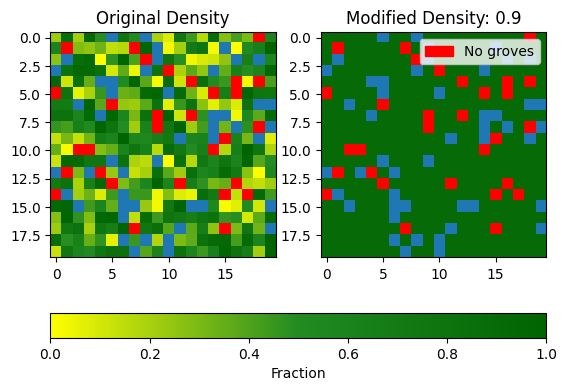

In [189]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors
import scipy as sp
import matplotlib.patches as mpatches

np.random.seed(5)

# Load data from url: https://github.com/drsmwhite/Xylella-spread-model/tree/master

FROM_DATA = False
MODIFY_DATA = True
PLOT_NO_GROVES = True
RANDOM_SEA = True

if FROM_DATA:
    mat = sp.io.loadmat("olivegrowthprop.mat")
    olive_prop = mat["olivegrowthprop"] # Phi
    H, W = olive_prop.shape # M, N
    sea_mask = olive_prop < 0
    no_grove_mask = olive_prop == 0

else:
    H = 20
    W = 20
    olive_prop = np.random.random([H,W])

    # set random sea cells (olive_prop < 0)
    sea_perc = 0.1
    if not RANDOM_SEA:
        arr = np.zeros([H,W])
        for i in range(2,10):
            for j in range(3,7):
                arr[i,j] = 1
        sea_mask = np.array(arr, dtype='bool')
    else:
        sea_mask = np.random.choice([True, False], size=H*W, p=[sea_perc, 1-sea_perc]).reshape(H,W)
    
    olive_prop[sea_mask] = -9999

    # set random null cells (olive_prop = 0)
    zero_perc = 0.1 # including sea
    zero_mask = np.random.choice([True, False], size=H*W, p=[zero_perc, 1-zero_perc]).reshape(H,W)
    no_grove_mask = np.logical_and(~sea_mask, zero_mask)
    olive_prop[no_grove_mask] = 0
grove_mask = olive_prop > 0

# Plot distribution of olive groves
cmap_custom = colors.LinearSegmentedColormap.from_list("", ["yellow", "forestgreen", "darkgreen"])
cmap_custom.set_under(color="tab:blue")
norm = colors.Normalize(vmin=0, vmax=1)
images = []

if not MODIFY_DATA:
    fig, ax = plt.subplots()
    images.append(ax.imshow(olive_prop, cmap=cmap_custom))
    ax.set_title("Olive Groves Density")
else:
    fig, ax = plt.subplots(1, 2)
    images.append(ax[0].imshow(olive_prop, cmap=cmap_custom))
    ax[0].set_title("Original Density")
    threshold = 0.9
    modified_olive_prop = olive_prop.copy()
    modified_olive_prop[modified_olive_prop > 0] = threshold
    images.append(ax[1].imshow(modified_olive_prop, cmap=cmap_custom))
    ax[1].set_title(f"Modified Density: {threshold}")

if PLOT_NO_GROVES:
    cmap_custom.set_bad(color="red")  # Red cells have no groves
    zero_patch = mpatches.Patch(color="red", label="No groves")
    masked_data = np.ma.masked_where(olive_prop == 0, olive_prop)

    if not MODIFY_DATA:
        images.append(ax.imshow(masked_data, cmap=cmap_custom))
        ax.legend(handles=[zero_patch], loc="upper right")
    else:
        modified_masked_data = np.ma.masked_where(modified_olive_prop == 0, modified_olive_prop)
        images.append(ax[0].imshow(masked_data, cmap=cmap_custom))
        images.append(ax[1].imshow(modified_masked_data, cmap=cmap_custom))
        ax[1].legend(handles=[zero_patch], loc="upper right")

for im in images:
    im.set_norm(norm)

cbar = fig.colorbar(images[0], ax=ax, orientation="horizontal", fraction=0.1)
cbar.set_label("Fraction")

plt.show()

In [123]:
# # Remove all trees in the buffer zone
# xp1, yp1 = [253, 212]
# xp2, yp2 = [278, 183]

# BW1 = 2 # bufferwidth1 eradication zone width
# BW2 = 13 # bufferwidth2 buffer zone width
# eff = 0.9 # eff control efficiency in the buffer zone
# timerun = 8 # how many years does the model run for?

# m = (yp1 - yp2) / (xp1 - xp2)
# B1 = yp1 - m * xp1
# B2_erad = B1 - BW1 * np.sqrt(m**2 + 1)
# B2_rog = B1 - (BW1 + BW2) * np.sqrt(m**2 + 1)

# for x in range(W):
#     for y in range(H):
#         if y < m*x+B1 and y > m*x+B2_erad and olive_prop[y,x] > 0:
#             olive_prop[y,x] = 0

# ax.plot((xp1, xp2), (yp1, yp2), 'ro-', linewidth=1) # infection line

# x_erad1 = xp1 - 2
# x_erad2 = xp2 - 4
# y_erad1 = A1 * x_erad1 + B2_erad
# y_erad2 = A1 * x_erad2 + B2_erad
# ax.plot((x_erad1, x_erad2), (y_erad1, y_erad2), 'bo-', linewidth=1) # eradication line (eradication zone limit)

# x_rog1 = xp1 - 5
# x_rog2 = xp2 - 9
# y_rog1 = A1 * x_rog1 + B2_rog
# y_rog2 = A1 * x_rog2 + B2_rog
# ax.plot((x_rog1, x_rog2), (y_rog1, y_rog2), 'bo-', linewidth=1) # roguing line (buffer zone limit)

# plt.show()

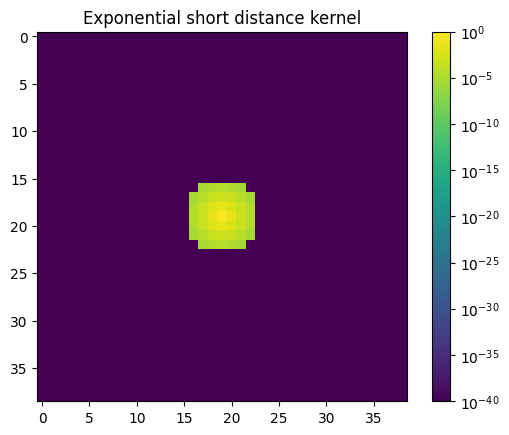

In [190]:
# Short distance kernel
beta = 0.1 # 0.1 mean dispersal distance

KERNEL = "exponential"

def exponential_kernel(x, y):
    global beta
    return np.exp(-(x**2 + y**2)**(1/2) / beta) #/ (2 * np.pi * beta**2)

def gaussian_kernel(x, y):
    global beta
    return np.exp(-(x**2 + y**2)/(2 * beta**2)) / np.sqrt(2 * np.pi * beta**2)

x = np.linspace(-(W-1), (W-1), 2*W-1)
y = np.linspace(-(H-1), (H-1), 2*H-1)

X, Y = np.meshgrid(x, y)

if KERNEL == "exponential": k = exponential_kernel(X,Y)
elif KERNEL == "gaussian": k = gaussian_kernel(X,Y)

k_min = np.min(k)
k_threshold = 1e-40
if k_min < k_threshold:
    k_min = k_threshold

fig, ax = plt.subplots()
im = ax.imshow(k, norm=colors.LogNorm(vmin=k_min, vmax=1))
if KERNEL == "exponential": ax.set_title("Exponential short distance kernel")
elif KERNEL == "gaussian": ax.set_title("Gaussian short distance kernel")
fig.colorbar(im, ax=ax)
plt.show()

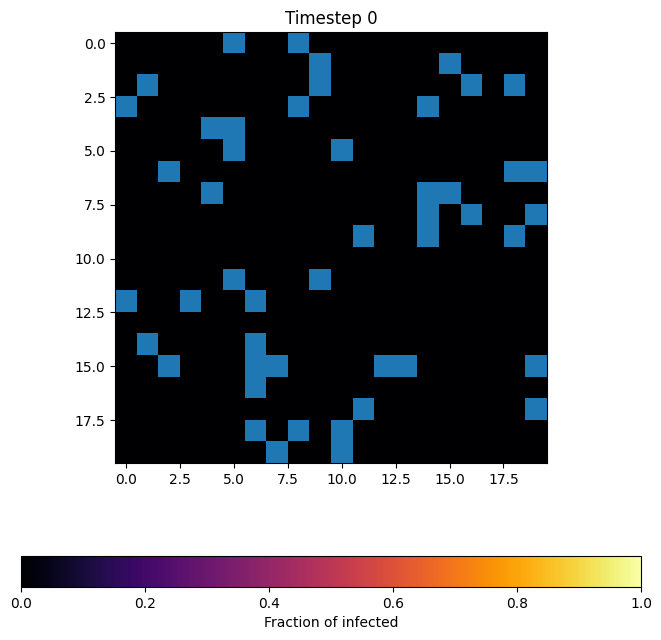

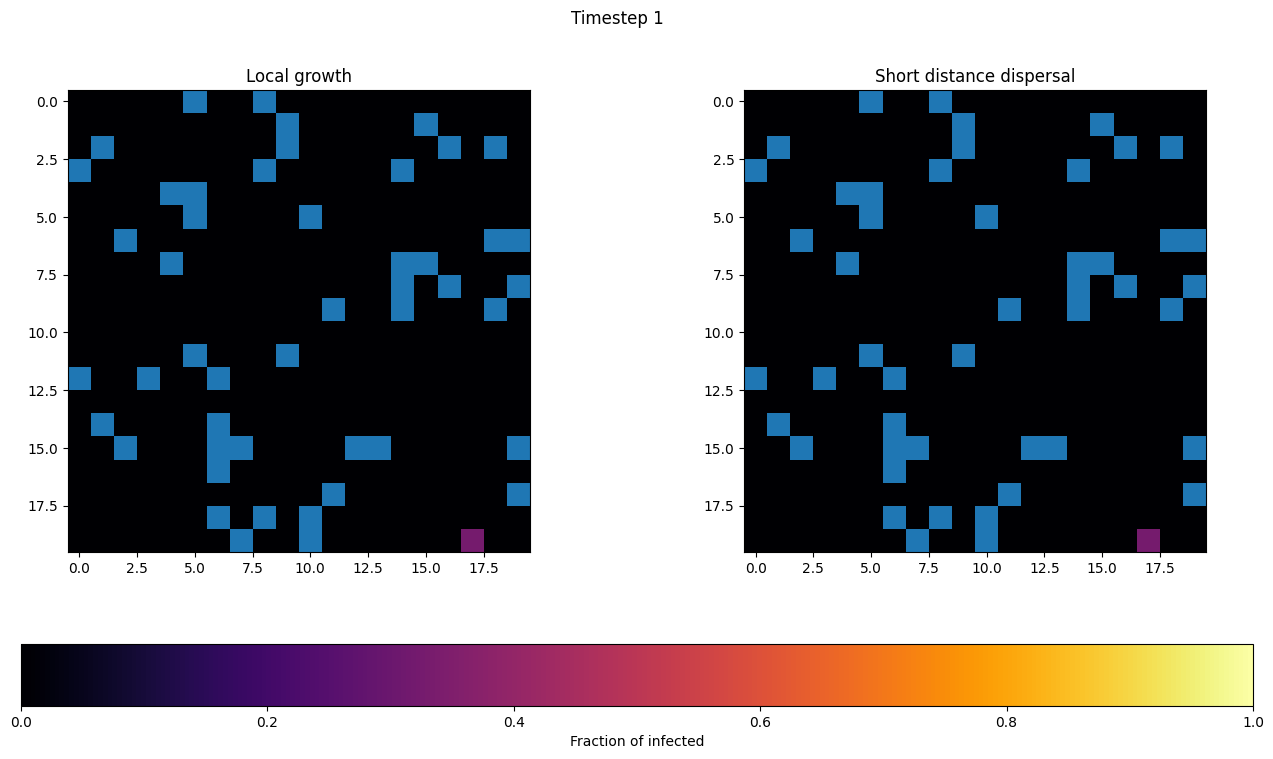

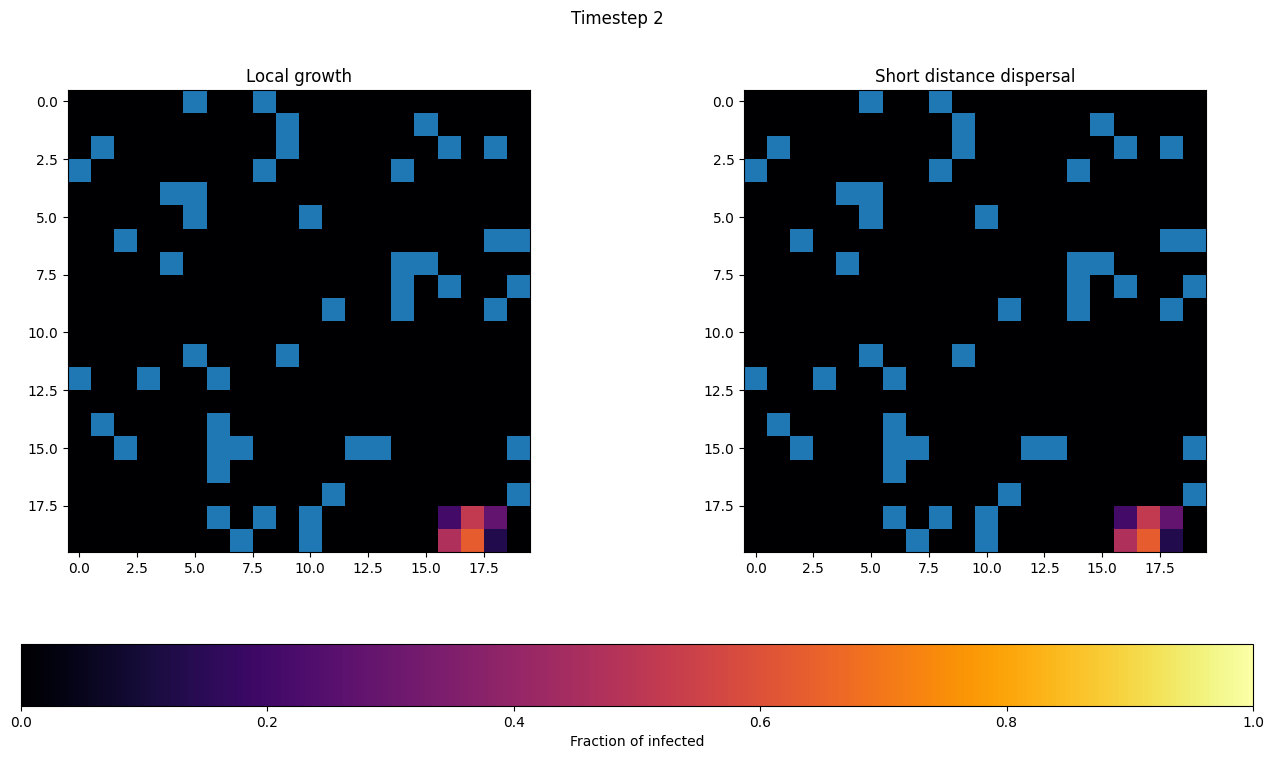

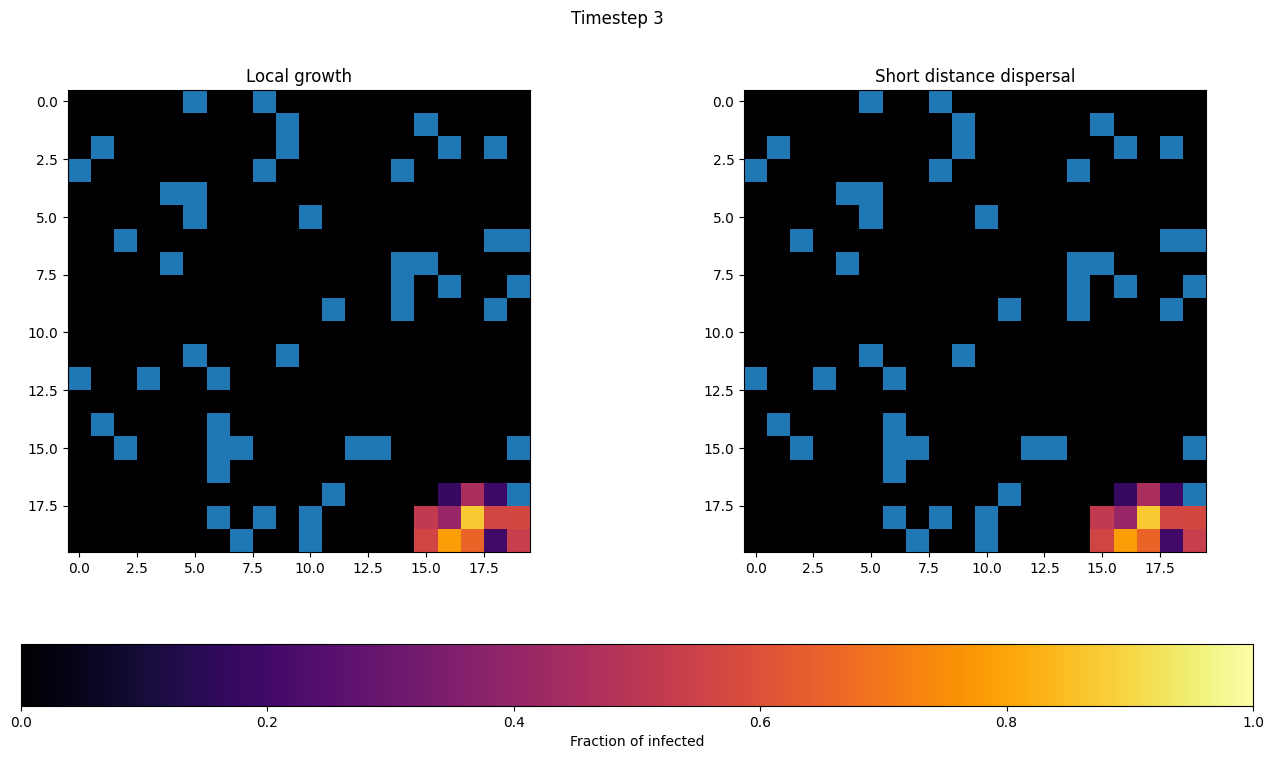

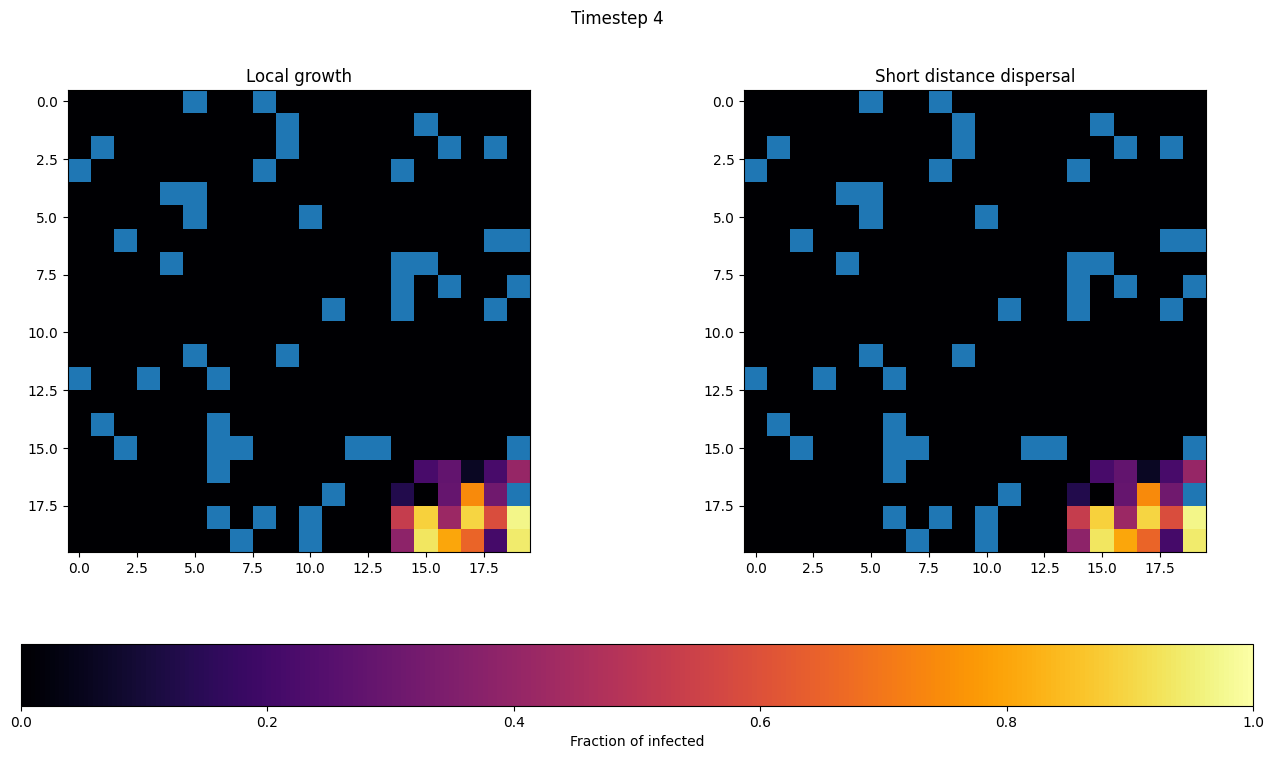

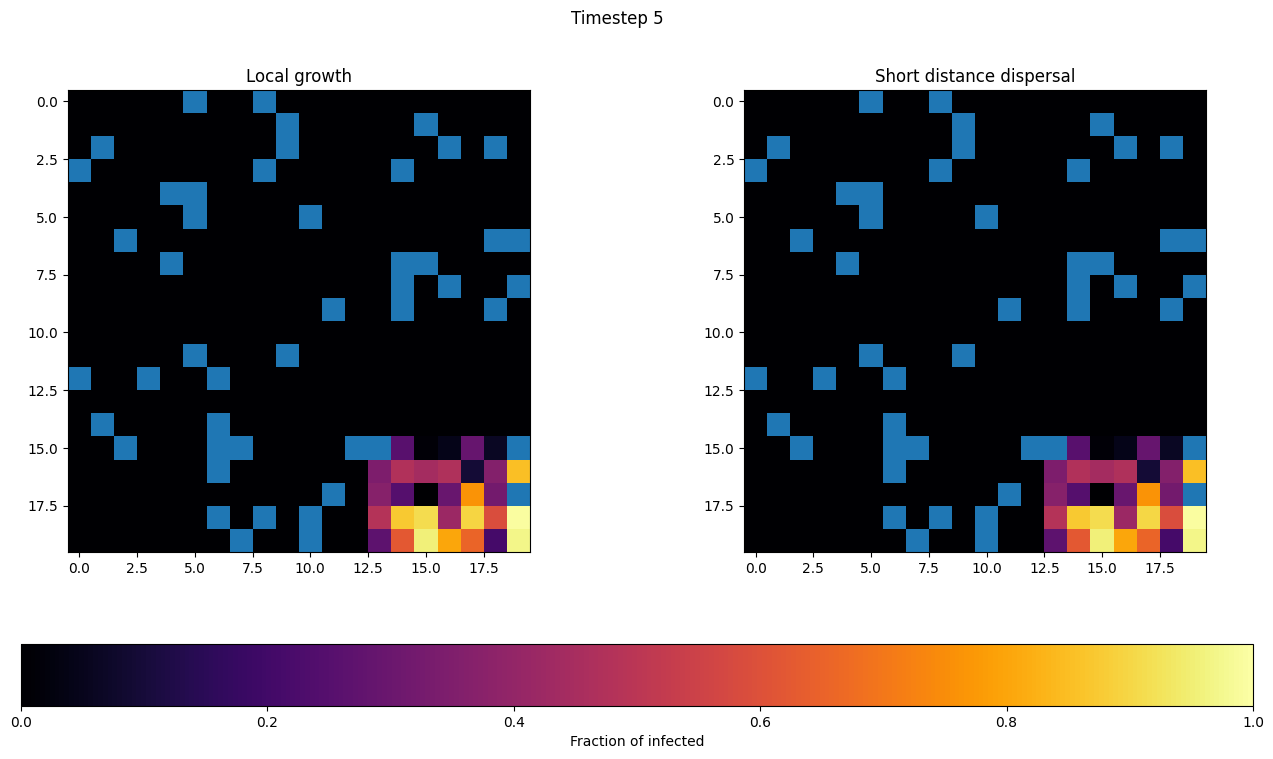

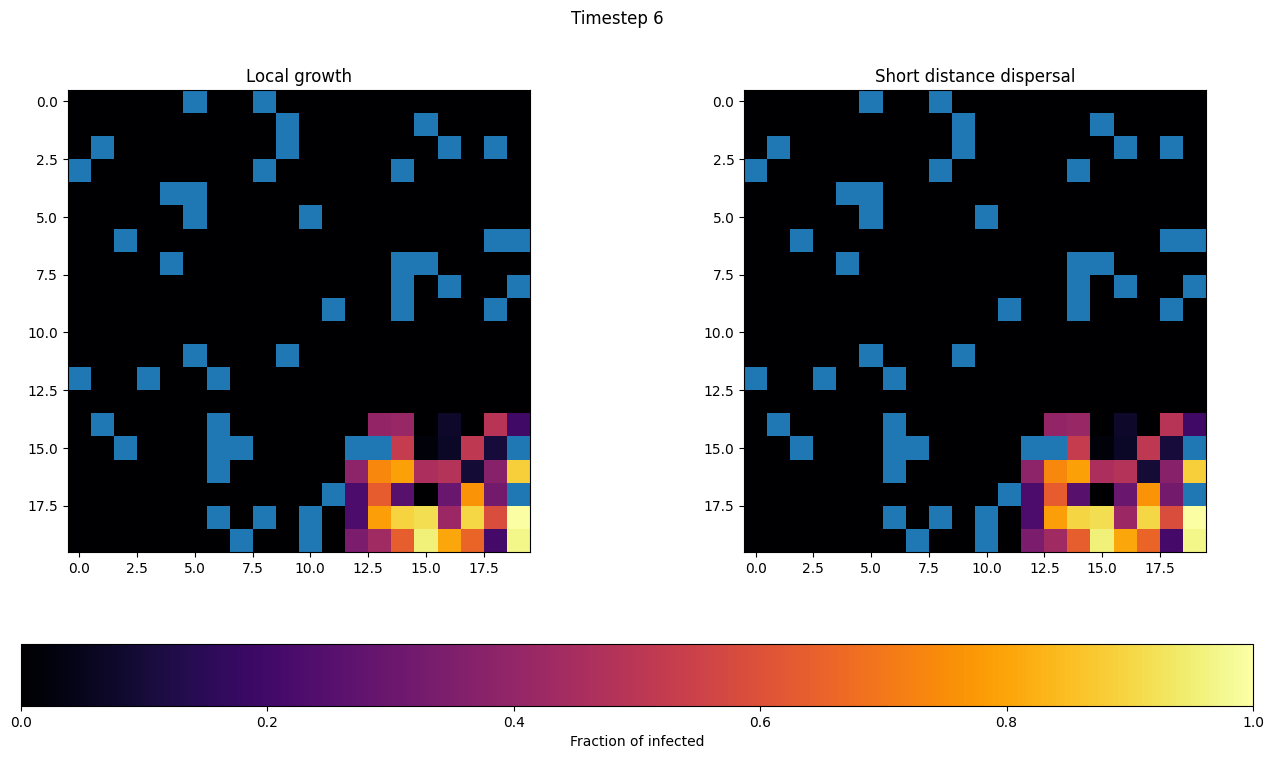

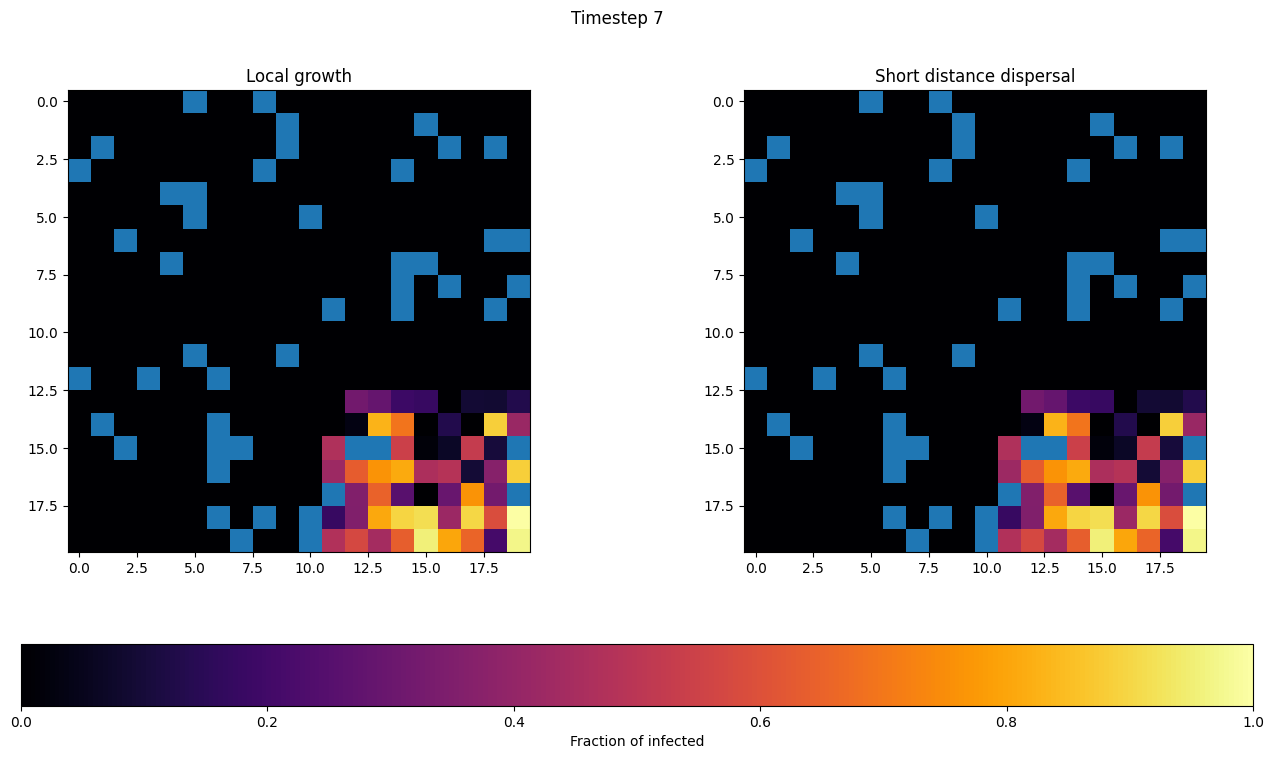

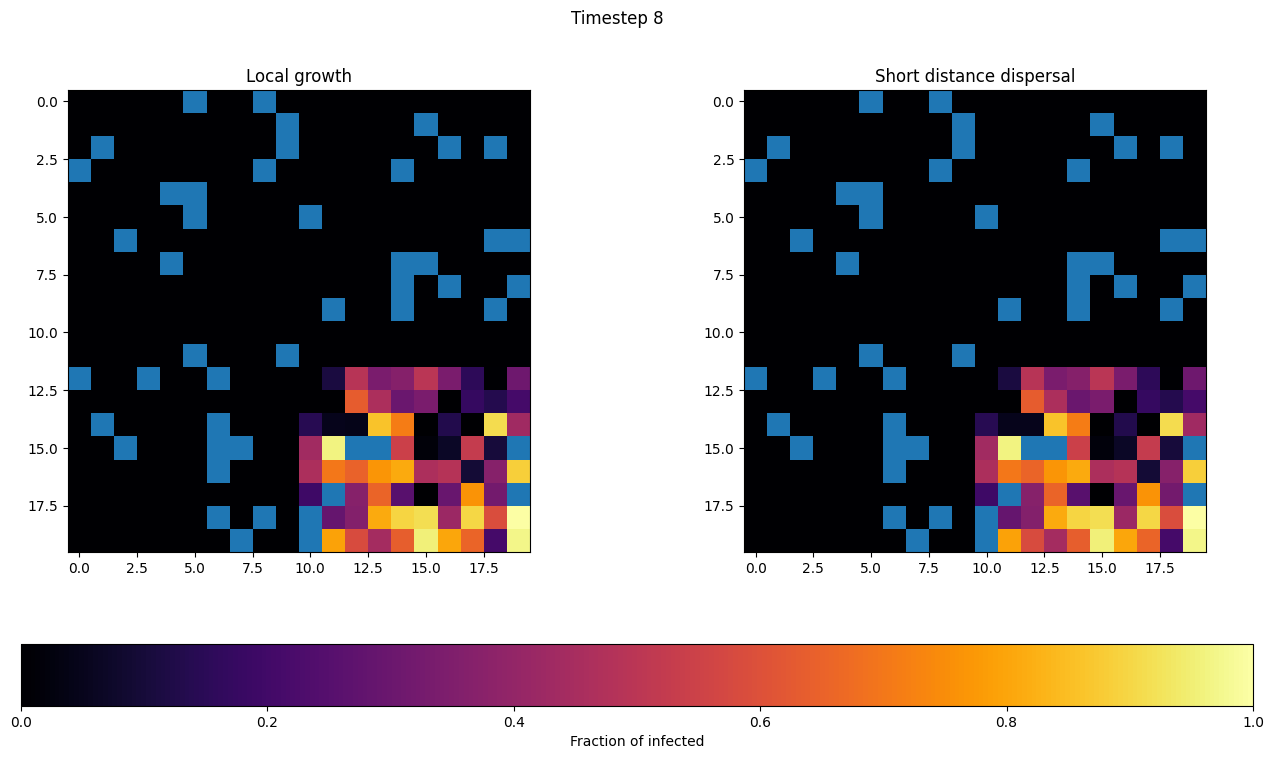

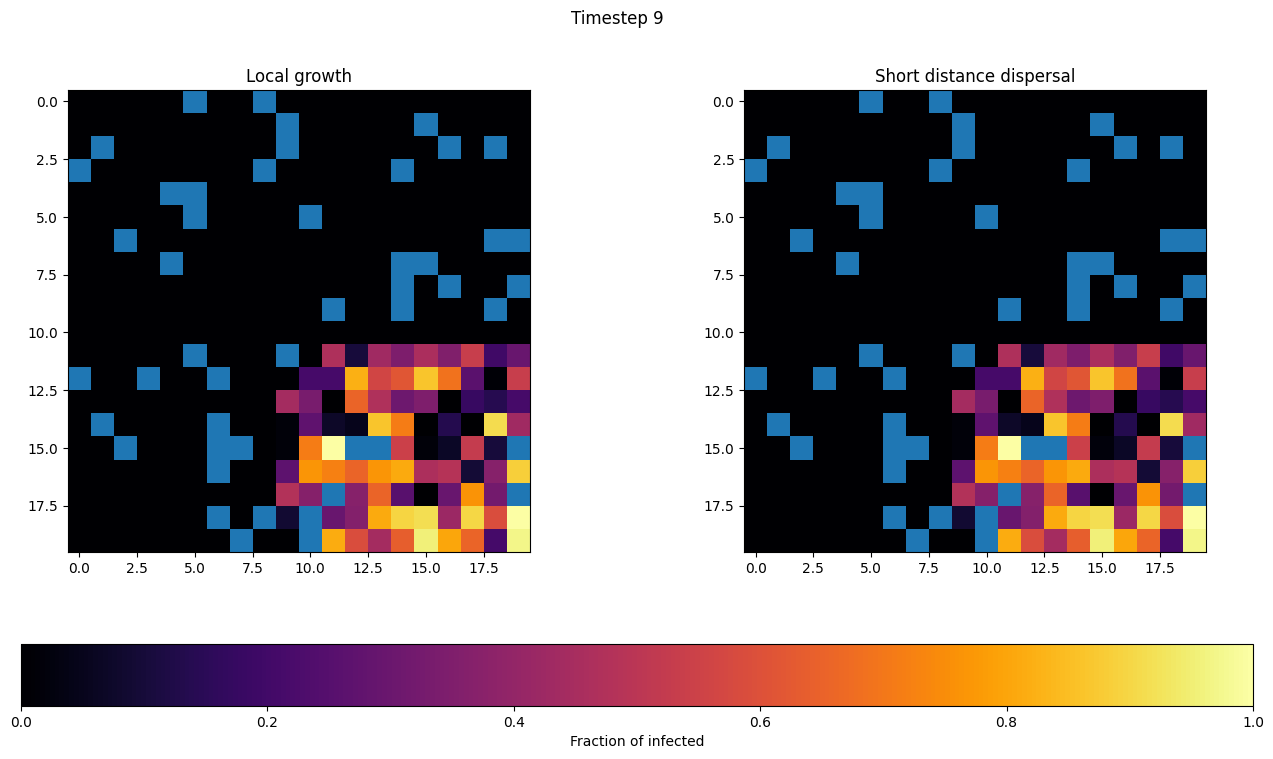

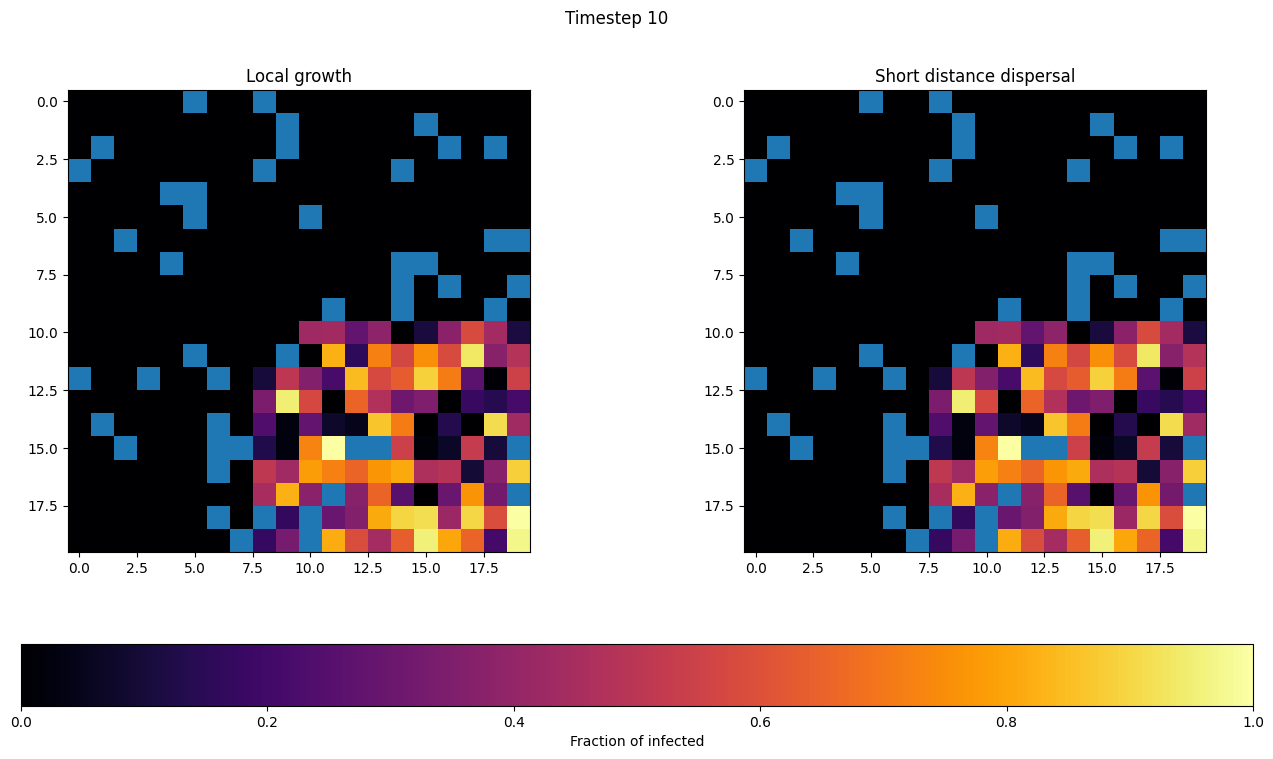

In [193]:
np.random.seed(13340)

RANDOM_SEED = True # True if FROM_DATA is False

# Gompertz model parameters
A = 3 # 3 kp rate of population growth
B = 14.069

# Carrying capacity
a = 0 # relative carrying capacity in non olive plants
K = olive_prop + a * (1 - olive_prop) # CC carrying capacity
K[sea_mask] = 0
tol = 1e-8 # 1e-8 numerical noise tolerance

# # Long distance kernel
# p = 0.2 # strattol stratified dispersal tolerance (threshold probability)
# M_max = 5 # maximum number of dispersers
# D = 20 # dispersal standard deviation

# SIMULATE DIFFUSION
time_steps = 10
U = np.zeros((time_steps+1, H, W)) # Fraction of infected

if RANDOM_SEED:
    grove_coordinates = np.argwhere(grove_mask)
    seed = grove_coordinates[np.random.choice(grove_coordinates.shape[0])]
else:
    seed = np.array([235,266])
U[0][tuple(seed)] = K[tuple(seed)] * np.exp(-B)

P = U.copy()
P[0][grove_mask] = U[0][grove_mask] / olive_prop[grove_mask]
P[0][sea_mask] = -9999
P[0][no_grove_mask] = 0

cmap_inferno = mpl.colormaps["inferno"]
cmap_inferno.set_under("tab:blue")

width = 8
fig, ax = plt.subplots(figsize=(width, width))
ax.set_title("Timestep 0")
im = ax.imshow(P[0], cmap=cmap_inferno, norm=norm)
cbar = fig.colorbar(im, ax=ax, orientation="horizontal")#, fraction=0.1)
cbar.set_label("Fraction of infected")
plt.show()

images = []

logNorm = colors.LogNorm(vmin=1e-60, vmax=1)
norm = colors.Normalize(vmin=0, vmax=1)

for t in range(time_steps):
    fig, ax = plt.subplots(1, 2, figsize=(width*2, width))
    images = []
    fig.suptitle(f"Timestep {t+1}")

    # Local growth
    U[t][U[t] < tol] = 0
    U[t+1] = K ** (1 - np.exp(-A)) * (U[t] ** np.exp(-A)) 
    P[t+1][grove_mask] = U[t+1][grove_mask] / olive_prop[grove_mask]
    P[t+1][sea_mask] = -9999;   U[t+1][sea_mask] = -9999
    P[t+1][no_grove_mask] = 0;  U[t+1][no_grove_mask] = 0

    ax[0].set_title("Local growth")
    # images.append(ax[0].imshow(U[t+1], cmap=cmap_inferno))
    images.append(ax[0].imshow(P[t+1], cmap=cmap_inferno))

    # Short distance dispersal
    U[t+1][U[t+1] < tol] = 0
    U[t+1] = sp.signal.convolve(U[t+1], k, mode="same", method="fft")
    P[t+1][grove_mask] = U[t+1][grove_mask] / olive_prop[grove_mask]
    P[t+1][sea_mask] = -9999;   U[t+1][sea_mask] = -9999
    P[t+1][no_grove_mask] = 0;  U[t+1][no_grove_mask] = 0

    ax[1].set_title("Short distance dispersal")
    # images.append(ax[1].imshow(U[t+1], cmap=cmap_inferno))
    images.append(ax[1].imshow(P[t+1], cmap=cmap_inferno))

    # Long distance dispersal

    for im in images:
        im.set_norm(norm)

    cbar = fig.colorbar(images[0], ax=ax, orientation="horizontal", fraction=0.1)
    cbar.set_label("Fraction of infected")
    plt.show()

In [ ]:
# # print(np.where(olive_prop < 0)) # collect all coordinates where olive_prop < 0: disease seed has to be inside the region, not in the sea. TODO
# # seed = np.array([235, 266]) # initial outbreak near Gallipoli

# print(U[1,:,:])

# U[2,:,:] = K ** (1 - np.exp(-A)) * (U[1,:,:] ** np.exp(-A))
# print(U[2,:,:])
# U[2,:,:] = sp.signal.fftconvolve(U[1,:,:], w, mode="same")

# fig, ax = plt.subplots()
# im = ax.imshow(U[0,:,:], cmap=cmap_custom, vmin=0, vmax=1)
# fig.colorbar(im)
# plt.show()

# for t in range(time_steps): # evolution
#     # Local population growth
#     U[t+1,:,:] = K ** (1 - np.exp(-A)) * (U[t,:,:] ** np.exp(-A))
    
#     print(U[t+1,:,:].shape)

#     # Short distance dispersal
#     U[t+1,:,:] = sp.signal.fftconvolve(U[t+1,:,:], w, mode="same")
#     # print(U[t+1,:,:])
#     # print(t)
#     # # if t % 10 == 0:
#     fig, ax = plt.subplots()
#     im = ax.imshow(U[t+1,:,:], cmap=cmap_custom, vmin=0, vmax=1)
#     fig.colorbar(im)
#     # plt.show()
#     # Long distance dispersal


# # # d = np.random.exponential(beta) # generate random distance according to short-distance dispersal kernel
# # # theta = np.random.random()*2*np.pi # generate random dispersal angle
# # # x = d * np.cos(theta)
# # # y = d * np.sin(theta)
# # # check that the dispersal doesn't go into the sea TODO

# # # Long distance dispersal TODO

In [ ]:
np.allclose(U[0,:,:], U[1,:,:], rtol=1e-10)

In [ ]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import pandas as pd

data2022 = pd.read_csv("Data/CAMP_2022.csv", encoding='latin-1') # , skiprows=
# pd.DataFrame(pd.read_excel("Data/CAMP_2022.xlsx"))

# read_file = pd.read_excel("Data/CAMP_2022.xlsx") 
# read_file.to_csv ("Data/CAMP_2022.csv",
#                   index = None, 
#                   header=True) 
# data2022 = pd.DataFrame(pd.read_csv("Data/CAMP_2022.csv")) 

display(data2022.head())

# Extract latitude and longitude
latitudes = data2022["LATITUDINE"].values
longitudes = data2022["LONGITUDINE"].values


In [ ]:
# TODO: gather all datas from yearly monitoring campaigns and do timeseries/animation of yearly advancement. 
# Just plot to see if there are holes in the continuation of the disease or if we are able to make an accurate map of the evolution

# # Create a figure and a basemap
# # lower_left = [40.5, 16.8]
# # upper_right = [41.0, 17.5]

# plt.figure(figsize=(10, 10))
# m = Basemap(projection='merc',
#             llcrnrlat=min(latitudes)-0.1, urcrnrlat=max(latitudes)+0.1,
#             llcrnrlon=min(longitudes)-0.1, urcrnrlon=max(longitudes)+0.1,
#             resolution='i') # c (crude), l (low), i (intermediate), h (high), f (full)

# # Draw coastlines and countries for context
# m.drawcoastlines()
# m.drawcountries()

# # Convert lat/long to map projection coordinates
# x, y = m(longitudes, latitudes)

# # Plot the points
# m.scatter(x, y, marker='o', color='red', s=0.1)

# # Title and show the plot
# plt.title('Tree Locations on Basemap')
# plt.show()
